# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали в другом проекте.

## Откроем и изучим файл

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')

Изучим файл с помощью функций **.head(), .info(), .describe(), .hist()**. Данные функции дадут представление о типах значений в каждом столбце, их рарпделениях и, возможно, о выбросах

In [3]:
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


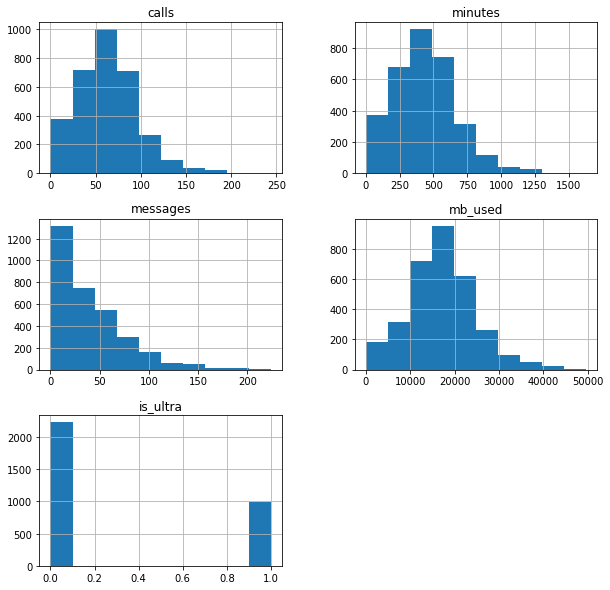

In [6]:
df.hist(figsize = (10,10));

В столбце **is_ultra** значения делятся на 1 и 0. Процентное соотношение единиц составляет 21,7%

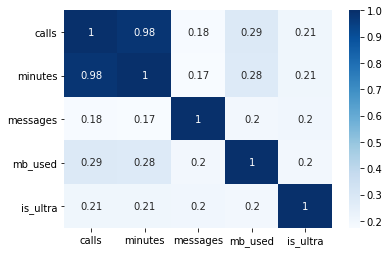

In [7]:
sns.heatmap(df.corr(), annot = True, cmap = 'Blues');

Посмотрели на матрицу корреляций между столбцами датафрейма. Лучшая корреляция у столбцов **calls** и **minutes**, что очевидно. У столбца **is_ultra** самая высокая корреляция со столбцами **calls**  и **minutes**

In [8]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Пропусков в датафрейме нету

In [9]:
df['is_ultra'].value_counts(normalize = True).round(2)

0    0.69
1    0.31
Name: is_ultra, dtype: float64

В столбце **is_ultra** единицы составляют 31%

In [10]:
df.duplicated().sum()

0

Дубликатов не найдено

Вывод по шагу 1 
* Открыт и изучен файл
* Просмотрели распределения значений в каждом столбце с помощью гистограмм
* Дубликатов и пропущенных значений в датафрейме не найдено
* Количество "1" в столбце is_ultra составляет 31%

## Разобьем данные на выборки

Наш *target variable* будет столбец **is_ultra**. В переменную *features* запишем значения всех столбцов датафрейма за исключением is_ultra

In [11]:
features = df.drop(['is_ultra'], axis = 1)
target = df['is_ultra']

Так как нам не предоставлено отдельной тестовой выборки, поделим исходный датафрейм в соотношении 3:1:1, т.е на 60, 20, 20 процентов. В 60 процентов выборки будут входить данные, на которых модель будет обучаться. Для этого с помощью метода **train_test_split** разделим выборку на 60 и 40 процентов между train и valid, а потом valid с помощью того же метода разобьем на valid и test и укажем параметр test_size = 0.50

In [12]:
df_train, df_valid = train_test_split(df, test_size = 0.40, random_state = 12345)

df_valid, df_test = train_test_split(df_valid, test_size = 0.50, random_state = 12345)

Запишем к каждой выборке переменные features и target

In [13]:
features_train = df_train.drop(['is_ultra'], axis = 1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis = 1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis = 1)
target_test = df_test['is_ultra']

## Исследуем модели

Работать будем с тремя моделями: **DecisionTreeClassifier, RandomForestClassifier, LogisticRegression**.

### DecisionTreeClassifier:

Для начала подберем оптимальную глубину дерева:

In [14]:
best_depth = 0
best_accuracy = 0

for depth in range(1,101):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth, criterion = 'gini')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    
    if accuracy > best_accuracy:
        best_depth = depth
        best_accuracy = accuracy
print('Оптимальная глубина:', best_depth)
print('Лучшая точность:', best_accuracy)

Оптимальная глубина: 3
Лучшая точность: 0.7853810264385692


Изменим гиперпараметр с gini на entropy

In [15]:
for criteria in ['gini', 'entropy']:
    for splitter in ['best', 'random']:
        model = DecisionTreeClassifier(random_state = 12345, max_depth = 3, criterion = criteria)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        print(accuracy_score(target_valid, predictions))
        print('Критерий:', criteria)
        print('Splitter:', splitter)

0.7853810264385692
Критерий: gini
Splitter: best
0.7853810264385692
Критерий: gini
Splitter: random
0.7853810264385692
Критерий: entropy
Splitter: best
0.7853810264385692
Критерий: entropy
Splitter: random


Никаких изменений. Параметры лучшей модели: глубина 3, точность 0.7853

### RandomForestClassifier

In [16]:
best_accuracy = 0
best_estimator = 0
for estimator in range(1,101):
    model = RandomForestClassifier(random_state = 12345, n_estimators = estimator)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    if accuracy_score(target_valid, predictions) > best_accuracy:
        best_accuracy = accuracy_score(target_valid, predictions)
        best_estimator = estimator
        
print('Лучшая точность:', best_accuracy)
print('Лучший эстиматор:', best_estimator)

Лучшая точность: 0.7947122861586314
Лучший эстиматор: 23


Лучшее количество эстиматоров –– 23. Поменяем bootstrap, warm_start и criterion

In [17]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 100, warm_start = False)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
print(accuracy_score(target_valid, predictions))

0.7853810264385692


In [18]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 100, warm_start = True)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
print(accuracy_score(target_valid, predictions))

0.7853810264385692


In [19]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 100, bootstrap = True)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
print(accuracy_score(target_valid, predictions))

0.7853810264385692


In [20]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 100, bootstrap = False)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
print(accuracy_score(target_valid, predictions))

0.7651632970451011


Стало только хуже. Оптимальные параметры модели: эстиматоры –– 23, точность –- 0.794

### Logistic Regression

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
best_iter = 0
best_solver = 0
best_accuracy = 0
for iter in range(1,101):
    for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
        model = LogisticRegression(random_state = 12345, max_iter = iter)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions)
    
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_iter = iter
            best_solver = solver 
print('Accuracy:', accuracy)
print('Iterations:', best_iter)
print('Solver:', best_solver)

Accuracy: 0.7107309486780715
Iterations: 39
Solver: newton-cg


Характеристики лучшей модели: точность –– 0.7107, iteractions –- 39, solver –- newton-cg

Общий вывод по моделям

* Протестировали и подобрали оптимальные параметры к алгоритму **DecisionTreeClassifier**. Показал себя неплохо, точность 78% при глубине дерева 3
* Исследована модель **RandomForestClassifier**. Лучший показатель точности 79% при n_estimators = 23
* Хуже всего себя показала LogisticRegression. Самая лучшая точность составляет 71% при параметрах iterations = 39, solver –– newton-cg

**У алгоритма RandomForestClassifier лучшие показатели**

## Проверим модель на тестовой выборке

Протестируем каждую модель на тестовой выборке и посмотрим на результат:

In [23]:
model = DecisionTreeClassifier(random_state = 12345, max_depth = 3)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('Accuracy of DecisionTreeClassifier: ',accuracy_score(target_test, predictions))


model = RandomForestClassifier(random_state = 12345, n_estimators = 23)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('Accuracy of RandomForestClassifier: ',accuracy_score(target_test, predictions))

model = LogisticRegression(random_state = 12345, max_iter = 39)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print('Accuracy of LogisticRegression: ',accuracy_score(target_test, predictions))

Accuracy of DecisionTreeClassifier:  0.7791601866251944
Accuracy of RandomForestClassifier:  0.7807153965785381
Accuracy of LogisticRegression:  0.6842923794712286


**RandomForestClassifier** показал себя лучше всех, хотя и **DecisionTreeClassifier** недалеко. Логистическая регрессия совсем подкачала

## Проверим модели на адекватность

Проверим адекватность лучшей модели (случайный лес) на основе методов precision, recall и f1 score

In [24]:
from sklearn.metrics import f1_score

In [25]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 23)
model.fit(features_train, target_train)

predictions = model.predict(features_test)

accuracy = accuracy_score(target_test, predictions)
precision = precision_score(target_test, predictions)
recall = recall_score(target_test, predictions)

print('Accuracy = ', accuracy)
print('Precision = ', precision)
print('Recall = ', recall)
print('F-score:', f1_score(target_test, predictions))

Accuracy =  0.7807153965785381
Precision =  0.6781609195402298
Recall =  0.5812807881773399
F-score: 0.6259946949602121


## Вывод

Проделанная работа:
 * Открыт и изучен файл с данными
 * Данные разбили на обучающую, валидационную и тестовую выборки в соотношении 3:1:1
 * Воспользовались тремя моделями классификации: **DecisionTreeClassifier, RandomForestClassifier, Logistic Regression**
 * По каждой модели подобрали оптимальные гиперпарпметры и сохранили лучшие модели для использования на тестовой выборке
 * Каждую модель протестировали на финальной выборке, лучшей оказалась модель **RandomForestClassifier** с количеством эстиматоров 23
 * Оценили адекватность модели. У Случайного Леса F-мера приемлемая для данной задачи –– 0,625